In [58]:
%pwd

'/Users/yc3958/Repo/disease_stigma'

In [59]:
# Set working directory to /disease_stigma
import os
os.chdir('/Users/yc3958/Repo/disease_stigma/')

In [60]:
# %pip uninstall -y numpy pandas gensim opencv-python opencv-contrib-python opencv-python-headless tensorflow numba

In [61]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Data preprocessing

In [62]:
import pandas as pd

file_path = os.path.join('data', 'original_mock', 'mock_articles_1980_2025.csv')

print("Current working directory:", os.getcwd())
print("File exists:", os.path.isfile(file_path))

try:
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    # Display the first 5 rows of the DataFrame
    print(f"Successfully read file: {file_path}")
    display(df.head())

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred while reading the file: {e}")

Current working directory: /Users/yc3958/Repo/disease_stigma
File exists: True
Successfully read file: data/original_mock/mock_articles_1980_2025.csv
Successfully read file: data/original_mock/mock_articles_1980_2025.csv


,GOID,Date,publisher,title,Text,year
0,1980adh000,1980-01-01,mock,adhd article 0,adhd dangerous disgusting impure immoral dirty...,1980
1,1980aut000,1980-01-01,mock,autism article 0,autism dangerous disgusting impure immoral dir...,1980
2,1980dys000,1980-01-01,mock,dyslexia article 0,dyslexia dangerous disgusting impure immoral d...,1980
3,1980dow000,1980-01-01,mock,down_syndrome article 0,down_syndrome dangerous disgusting impure immo...,1980
4,1980tou000,1980-01-01,mock,tourette_syndrome article 0,tourette_syndrome dangerous disgusting impure ...,1980


In [ ]:
# Check data distribution across years and diseases
print("Data Distribution Analysis")
print("=" * 60)
print(f"\nTotal rows: {len(df):,}")
print(f"Year range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nArticles per year:")
year_counts = df.groupby('year').size().sort_index()
print(year_counts)
print(f"\nMean articles per year: {year_counts.mean():.0f}")
print(f"Median articles per year: {year_counts.median():.0f}")
print(f"Min/Max: {year_counts.min()}/{year_counts.max()}")

# Check for years with very few articles (may affect model quality)
sparse_years = year_counts[year_counts < 100]
if len(sparse_years) > 0:
    print(f"\n⚠️  Warning: {len(sparse_years)} years have <100 articles:")
    print(sparse_years)

In [63]:
!python data_prep/prepare_corpus.py \
  --input-path data/original_mock/mock_articles_1980_2025.csv \
  --text-column Text --title-column title --date-column Date \
  --disease-list-path reference_data/Disease_list_5.12.20_uncorrupted.csv \
  --output-root data/preprocessed --write-manifest

Loaded 34 disease name mappings from reference_data/Disease_list_5.12.20_uncorrupted.csv
Finished writing pickles: 7500 kept, IDs not used 0 skipped empty, 0 skipped below length threshold
Finished writing pickles: 7500 kept, IDs not used 0 skipped empty, 0 skipped below length threshold


In [64]:
!ls -l data/preprocessed

total 0
drwxr-xr-x@ 4 yc3958  staff  128 Nov 23 17:12 NData_1980
drwxr-xr-x@ 4 yc3958  staff  128 Nov 23 17:12 NData_1983
drwxr-xr-x@ 4 yc3958  staff  128 Nov 23 17:12 NData_1986
drwxr-xr-x@ 4 yc3958  staff  128 Nov 23 17:12 NData_1989
drwxr-xr-x@ 4 yc3958  staff  128 Nov 23 17:12 NData_1992
drwxr-xr-x@ 4 yc3958  staff  128 Nov 23 17:12 NData_1995
drwxr-xr-x@ 4 yc3958  staff  128 Nov 23 17:12 NData_1998
drwxr-xr-x@ 4 yc3958  staff  128 Nov 23 17:12 NData_2001
drwxr-xr-x@ 4 yc3958  staff  128 Nov 23 17:12 NData_2004
drwxr-xr-x@ 4 yc3958  staff  128 Nov 23 17:12 NData_2007
drwxr-xr-x@ 4 yc3958  staff  128 Nov 23 17:12 NData_2010
drwxr-xr-x@ 4 yc3958  staff  128 Nov 23 17:12 NData_2013
drwxr-xr-x@ 4 yc3958  staff  128 Nov 23 17:12 NData_2016
drwxr-xr-x@ 4 yc3958  staff  128 Nov 23 17:12 NData_2019
drwxr-xr-x@ 4 yc3958  staff  128 Nov 23 17:12 NData_2022


In [65]:
!ls -l data/preprocessed/NData_1980

total 784
-rw-r--r--@ 1 yc3958  staff  371611 Nov 24 11:30 corpus_1980.pkl
-rw-r--r--@ 1 yc3958  staff     601 Nov 24 11:30 manifest.json


In [66]:
!cat data/preprocessed/NData_1980/manifest.json

{
  "year": 1980,
  "pickle": "corpus_1980.pkl",
  "article_count": 500,
  "generated_at": "2025-11-24T16:30:35.225287+00:00",
  "source_csv": "data/original_mock/mock_articles_1980_2025.csv",
  "columns": {
    "title": "title",
    "text": "Text",
    "date": "Date",
    "id": null
  },
  "default_year": null,
  "min_body_chars": 0,
  "processing_steps": [
    "clean_text (collapse whitespace, strip)",
    "split_sentences (regex-based)",
    "join sentences with SENTENCEBOUNDARYHERE",
    "drop duplicates by id when provided",
    "drop empty rows",
    "drop rows below min_body_chars"
  ]
}

# Trainining

## Train phrase model for a 3-year window

In [ ]:
# Global parameters
start_year = 1980
end_year = 2000 # TODO: change back to 2024 for official run
boots = 5 # TODO: change back to 50 for official run
year_interval = 3
min_count = 1 # TODO: change back to 30 for official run
lexicon_min_count = 1 # TODO: change back to 30 for official run

## Performance considerations for large dataset (80k rows, 40 years)

**Time estimates for full run with 50 bootstraps:**
- Preprocessing: ~2-5 minutes
- Training phrasers: ~5-10 minutes
- Training Word2Vec models: ~4-8 hours (15 windows × 50 bootstraps)
- Computing stigma scores: ~1-2 hours
- **Total: ~6-11 hours** (can run overnight)

**Memory usage:** ~4-8 GB RAM for models
**Disk space:** ~5-10 GB for all models and results

**Tips for faster iteration:**
1. Start with smaller subset (e.g., `end_year = 2000`, `boots = 5`) to validate pipeline
2. Test on one window before running full pipeline
3. Use `--sleep 0` to skip delays between model training (already set)
4. Increase `--workers` if you have more CPU cores available
5. Once validated, run full dataset overnight with 50 bootstraps

In [68]:
import sys, os
sys.path.insert(0, os.getcwd())

In [69]:
%run training/training_phraser.py \
    --start-year {start_year} \
    --end-year {end_year} \
    --year-interval {year_interval} \
    --raw-data-root data/preprocessed \
    --modeling-dir-base outputs/models


Training bigrammer for 1980-1982
[SKIP] No data for year 1981: both NData and ContempData missing
[SKIP] No data for year 1982: both NData and ContempData missing
Training bigrammer for 1983-1985
[SKIP] No data for year 1984: both NData and ContempData missing
[SKIP] No data for year 1985: both NData and ContempData missing
Training bigrammer for 1986-1988
[SKIP] No data for year 1987: both NData and ContempData missing
[SKIP] No data for year 1988: both NData and ContempData missing
Training bigrammer for 1989-1991
[SKIP] No data for year 1990: both NData and ContempData missing
[SKIP] No data for year 1991: both NData and ContempData missing
Training bigrammer for 1986-1988
[SKIP] No data for year 1987: both NData and ContempData missing
[SKIP] No data for year 1988: both NData and ContempData missing
Training bigrammer for 1989-1991
[SKIP] No data for year 1990: both NData and ContempData missing
[SKIP] No data for year 1991: both NData and ContempData missing
Training bigrammer for

In [70]:
!ls -l outputs/models/phrasers

total 168
-rw-r--r--@ 1 yc3958  staff  10401 Nov 24 11:30 bigrammer_1980_1982
-rw-r--r--@ 1 yc3958  staff  10388 Nov 24 11:30 bigrammer_1983_1985
-rw-r--r--@ 1 yc3958  staff  10373 Nov 24 11:30 bigrammer_1986_1988
-rw-r--r--@ 1 yc3958  staff  10450 Nov 24 11:30 bigrammer_1989_1991
-rw-r--r--@ 1 yc3958  staff  10414 Nov 24 11:30 bigrammer_1992_1994
-rw-r--r--@ 1 yc3958  staff  10428 Nov 24 11:30 bigrammer_1995_1997
-rw-r--r--@ 1 yc3958  staff  10395 Nov 24 11:30 bigrammer_1998_2000


## Train bootstrapped Word2Vec models

In [71]:
# !git pull

In [72]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/yc3958/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/yc3958/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [73]:
%run training/training_w2v_booted.py \
  --start-year {start_year} \
  --end-year {end_year} \
  --year-interval {year_interval} \
  --boots {boots} \
  --min-count {min_count} \
  --iterations 3 \
  --window 10 \
  --vector-size 300 \
  --sleep 0 \
  --raw-data-root data/preprocessed \
  --modeling-dir-base outputs/models
# TODO: change boots back to 25 for official run
# TODO: change min-count back to 50 for official run

[1/7] Training W2V for 1980-1982
[SKIP] No data for year 1981: both NData and ContempData missing
[SKIP] No data for year 1982: both NData and ContempData missing
[SKIP] No data for year 1981: both NData and ContempData missing
[SKIP] No data for year 1982: both NData and ContempData missing
[SKIP] No data for year 1981: both NData and ContempData missing
[SKIP] No data for year 1982: both NData and ContempData missing
[SKIP] No data for year 1981: both NData and ContempData missing
[SKIP] No data for year 1982: both NData and ContempData missing
[SKIP] No data for year 1981: both NData and ContempData missing
[SKIP] No data for year 1982: both NData and ContempData missing
[SKIP] No data for year 1981: both NData and ContempData missing
[SKIP] No data for year 1982: both NData and ContempData missing
[SKIP] No data for year 1981: both NData and ContempData missing
[SKIP] No data for year 1982: both NData and ContempData missing
[SKIP] No data for year 1981: both NData and ContempData 

# Validation

In [74]:
!ls outputs/models/BootstrappedModels/1980_1982

CBOW_300d__win10_min1_iter3_1980_1982_boot0
CBOW_300d__win10_min1_iter3_1980_1982_boot1
CBOW_300d__win10_min1_iter3_1980_1982_boot2
CBOW_300d__win10_min1_iter3_1980_1982_boot3
CBOW_300d__win10_min1_iter3_1980_1982_boot4
allarticles_tabsep_1980_1982tempboot
training_manifest.json


In [75]:
# !python validation/validating_overall_w2v_models.py --model-path outputs/models/BootstrappedModels/1980_1982/CBOW_300d__win10_min50_iter3_1980_1982_boot0

# Compute stigma scores per dimension

In [76]:
%run analysis/write_stigma_scores.py \
    --start-year {start_year} \
    --end-year {end_year} \
    --year-interval {year_interval} \
    --boots {boots} \
    --modeling-dir-base outputs/models \
    --results-dir outputs/results \
    --lexicon-min-count {lexicon_min_count} \
    --plotting-groups neurodevelopmental
    
# TODO: Change boots back to 25 for official run
# TODO: Remove lexicon-min-count for official run

[INFO] Starting dimension 'danger'
[INFO] Using model_prefix from manifest: CBOW_300d__win10_min1_iter3 (year 1980-1982)
Skipping folded term epilepsy_folded: missing 'epilepsy' or 'epileptic' in vocab.
Skipping folded term drug_addiction_folded: missing 'drug_addiction' or 'drug_addict' in vocab.
Skipping folded term obesity_folded: missing 'obesity' or 'obese' in vocab.
[INFO] Writing 15 rows for danger 1980 to outputs/results/tempdanger1980.csv
[INFO] Using model_prefix from manifest: CBOW_300d__win10_min1_iter3 (year 1983-1985)
[INFO] Writing 15 rows for danger 1980 to outputs/results/tempdanger1980.csv
[INFO] Using model_prefix from manifest: CBOW_300d__win10_min1_iter3 (year 1983-1985)
[INFO] Writing 15 rows for danger 1983 to outputs/results/tempdanger1983.csv
[INFO] Using model_prefix from manifest: CBOW_300d__win10_min1_iter3 (year 1986-1988)
[INFO] Writing 15 rows for danger 1983 to outputs/results/tempdanger1983.csv
[INFO] Using model_prefix from manifest: CBOW_300d__win10_m

In [77]:
!ls outputs/results/temp*1980.csv


outputs/results/tempdanger1980.csv     outputs/results/tempimmorality1980.csv
outputs/results/tempdisgust1980.csv    outputs/results/tempimpurity1980.csv


# Aggregate and plot

In [78]:
%run analysis/aggregating_stigma_index.py \
  --start-year {start_year} --end-year {end_year} --year-interval {year_interval} \
  --dimensions danger disgust immorality impurity \
  --input-dir outputs/results

In [79]:
import pandas as pd

df = pd.read_csv("outputs/results/stigmaindex_aggregated_temp_92CI.csv")
print("Rows:", len(df))
print(df.head())

# Quick sanity: non-NaN means and counts per plotting group
print(df[['Reconciled_Name','Year','PlottingGroup','count','mean']].head())
print(df[df['mean'].notna()].groupby('PlottingGroup')['mean'].count())


Rows: 21
  Reconciled_Name  Year       PlottingGroup  count      mean       std  \
0            ADHD  1980  neurodevelopmental      5  0.639666  0.039244   
1            ADHD  1983  neurodevelopmental      5  0.521215  0.033290   
2            ADHD  1986  neurodevelopmental      5  0.478768  0.016449   
3            ADHD  1989  neurodevelopmental      5  0.487021  0.040228   
4            ADHD  1992  neurodevelopmental      5  0.465526  0.007526   

        min       CI4      CI50      CI96       max    Dimension  
0  0.585483  0.590893  0.641755  0.682346  0.685380  stigmaindex  
1  0.468887  0.475199  0.537989  0.549593  0.551553  stigmaindex  
2  0.454962  0.458109  0.477409  0.497366  0.499224  stigmaindex  
3  0.448488  0.451186  0.474909  0.543335  0.552821  stigmaindex  
4  0.454877  0.456397  0.465443  0.474555  0.476010  stigmaindex  
  Reconciled_Name  Year       PlottingGroup  count      mean
0            ADHD  1980  neurodevelopmental      5  0.639666
1            ADHD  198

In [80]:
import pandas as pd
df = pd.read_csv("outputs/results/stigmaindex_aggregated_temp_92CI.csv")
print("Non‑NaN rows:", df[df["mean"].notna()].shape)
print(df[df["mean"].notna()][["Reconciled_Name","Year","PlottingGroup","count","mean"]].head(20))


Non‑NaN rows: (21, 12)
   Reconciled_Name  Year       PlottingGroup  count      mean
0             ADHD  1980  neurodevelopmental      5  0.639666
1             ADHD  1983  neurodevelopmental      5  0.521215
2             ADHD  1986  neurodevelopmental      5  0.478768
3             ADHD  1989  neurodevelopmental      5  0.487021
4             ADHD  1992  neurodevelopmental      5  0.465526
5             ADHD  1995  neurodevelopmental      5  0.450755
6             ADHD  1998  neurodevelopmental      5  0.423602
7           Autism  1980  neurodevelopmental      5  0.584536
8           Autism  1983  neurodevelopmental      5  0.505895
9           Autism  1986  neurodevelopmental      5  0.443394
10          Autism  1989  neurodevelopmental      5  0.444441
11          Autism  1992  neurodevelopmental      5  0.460934
12          Autism  1995  neurodevelopmental      5  0.467604
13          Autism  1998  neurodevelopmental      5  0.404848
14        Dyslexia  1980  neurodevelopmental   

## Plot

In [81]:
%run analysis/plotting_bootstrapped.py \
  --dimension stigmaindex \
  --min-count 0 \
  --results-dir outputs/results 
  
# TODO: change min-count back to 20 (or remove it) for official run

[INFO] Saved plot: outputs/results/neurodevelopmental_stigmaindex_Diseases_92CI_median.jpg


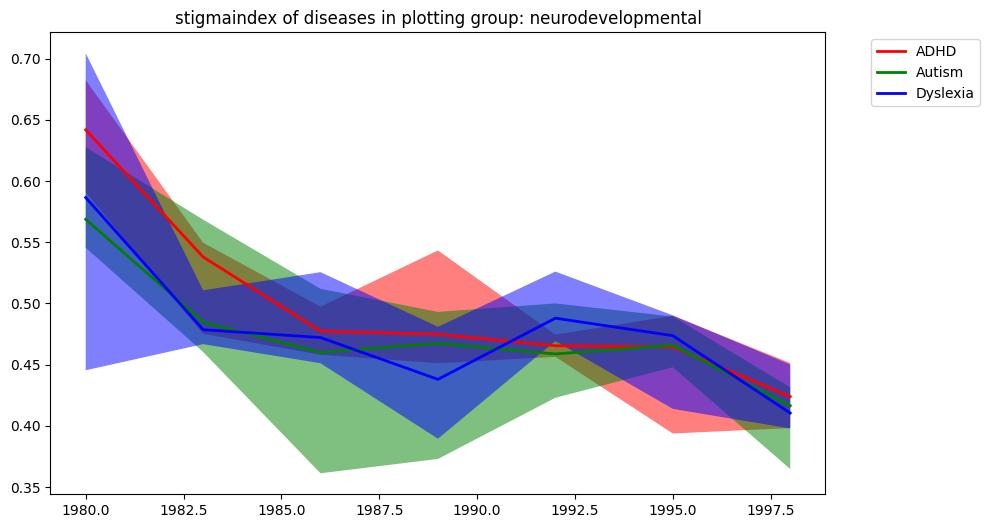

In [82]:
from pathlib import Path
from IPython.display import Image, display

plot_dir = Path("outputs/results")  # adjust if you used a different --output-dir
for img_path in sorted(plot_dir.glob("*neurodevelopmental*.jpg")):
    display(Image(filename=str(img_path)))